In [1]:
import os
import pprint

import numpy as np
from brian2 import *
from brian2modelfitting import *

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# read input and output traces
def read_io_traces(out_trace_filename='out_trace_ground_truth'):
    try:
        path_to_out = os.path.join('data', out_trace_filename + '.npy')
        out_trace = np.load(path_to_out)
    except FileNotFoundError as e:
        print(e, '\nReading ground truth trace instead.')
        path_to_out = os.path.join('data', 'out_trace_ground_truth.npy')
        out_trace = np.load(path_to_out)
    finally:
        path_to_inp = os.path.join('data', 'inp_trace.npy')
        inp_trace = np.load(path_to_inp)
        return inp_trace, out_trace

In [4]:
# fit the data
def fit_traces(out_trace_filename='out_trace_ground_truth'):
    # instatiate optimize, metric and fitter
    optimizer = NevergradOptimizer()
    metric = MSEMetric(t_start=50*ms)
    
    # load traces
    inp_trace, out_trace = read_io_traces(out_trace_filename)

    # instantiate fitter
    fitter = TraceFitter(model=eqs, dt=dt, n_samples=60,
                         input={'I_inj': inp_trace.reshape(1, -1)*uA*cm**-2*area},
                         output={'V': out_trace.reshape(1, -1)*mV},
                         param_init=init_conds,
                         method='exponential_euler')

    # multiround fitting
    res, error = fitter.fit(n_rounds=5,
                            optimizer=optimizer, metric=metric,
                            callback='progressbar',
                            g_l=[0.1*mS*cm**-2*area, 1.*mS*cm**-2*area],
                            g_Na=[60.*mS*cm**-2*area, 180.*mS*cm**-2*area],
                            g_K=[10.*mS*cm**-2*area, 50.*mS*cm**-2*area])

    # fitted traces given best values for free parameters stored in `res`
    fits = fitter.generate_traces()
    
    return dict(fitted_params=res,
                error=error,
                recordings=out_trace,
                fitted_traces=fits.ravel()/mV)

In [5]:
# set parameters
area = 1000*um**2
C_m = 1.*ufarad*cm**-2*area
E_l = -54.387*mV
E_K = -77.*mV
E_Na = 50.*mV
dt = 0.01*ms
init_conds = {'V': -65*mV, 'm': 0.05, 'h': 0.6, 'n': 0.32}
true_params = {'g_l': 0.3*mS*cm**-2*area,
               'g_Na': 120.*mS*cm**-2*area,
               'g_K': 36.*mS*cm**-2*area}
inp_trace, out_trace_ground_truth = read_io_traces('out_trace_ground_truth')

In [6]:
# set model definintion
eqs = '''
    # ode system
    dV/dt = ((I_inj
          - g_Na * m ** 3 * h * (V - E_Na)
          - g_K * n**4 * (V - E_K)
          - g_l * (V - E_l)) / C_m) : volt
    dm/dt = alpha_m * (1.0 - m) - beta_m * m : 1
    dh/dt = alpha_h * (1.0 - h) - beta_h * h : 1
    dn/dt = alpha_n * (1.0 - n) - beta_n * n : 1

    alpha_m = (0.1*mV**-1) * (V + 40.*mV) / (1. - exp(-(V + 40.*mV) / (10.*mV)))/ms : Hz
    beta_m = 4. * exp(-(V + 65.*mV) / (18.*mV))/ms : Hz
    alpha_h = 0.07 * exp(-(V + 65.*mV) / (20.*mV))/ms : Hz
    beta_h = 1. / (1. + exp(-(V + 35.*mV) / (10.*mV)))/ms : Hz
    alpha_n = (0.01*mV**-1) * (V + 55.*mV) / (1. - exp(-(V + 55.*mV) / (10.*mV)))/ms : Hz
    beta_n = 0.125 * exp(-(V + 65.*mV) / (80.*mV))/ms : Hz

    # parameters to fit
    g_Na : siemens (constant)
    g_K : siemens (constant)
    g_l : siemens (constant)
    '''

In [7]:
# fit measured noisy traces
ret_measured = fit_traces(out_trace_filename='out_trace_measured')

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
# fit filtered traces
ret_filtered = fit_traces(out_trace_filename='out_trace_filtered')

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# ground truth ion channel values
print(f'{true_params = }')

true_params = {'g_l': 3. * nsiemens, 'g_Na': 1.2 * usiemens, 'g_K': 0.36 * usiemens}


In [10]:
# noisy fits
pprint.pprint(ret_measured)

{'error': 1674.19161659 * mvolt2,
 'fitted_params': {'g_K': 0.43822847 * usiemens,
                   'g_Na': 1.66531826 * usiemens,
                   'g_l': 4.56160788 * nsiemens},
 'fitted_traces': array([-65.        , -64.99240151, -64.98476613, ..., -74.12840062,
       -74.11615403, -74.10387038]),
 'recordings': array([-64.19269057, -94.87453603,  -8.45305335, ..., -38.03995578,
       -91.5161269 , -21.8116117 ])}


In [11]:
# filtered fits
pprint.pprint(ret_filtered)

{'error': 111.79558123 * mvolt2,
 'fitted_params': {'g_K': 0.38088829 * usiemens,
                   'g_Na': 1.32202991 * usiemens,
                   'g_l': 3.30369332 * nsiemens},
 'fitted_traces': array([-65.        , -65.00145684, -65.00281762, ..., -73.50234629,
       -73.6507609 , -73.78693341]),
 'recordings': array([-64.19269057, -64.19280584, -64.19316552, ..., -70.60046056,
       -70.66044536, -70.72033823])}


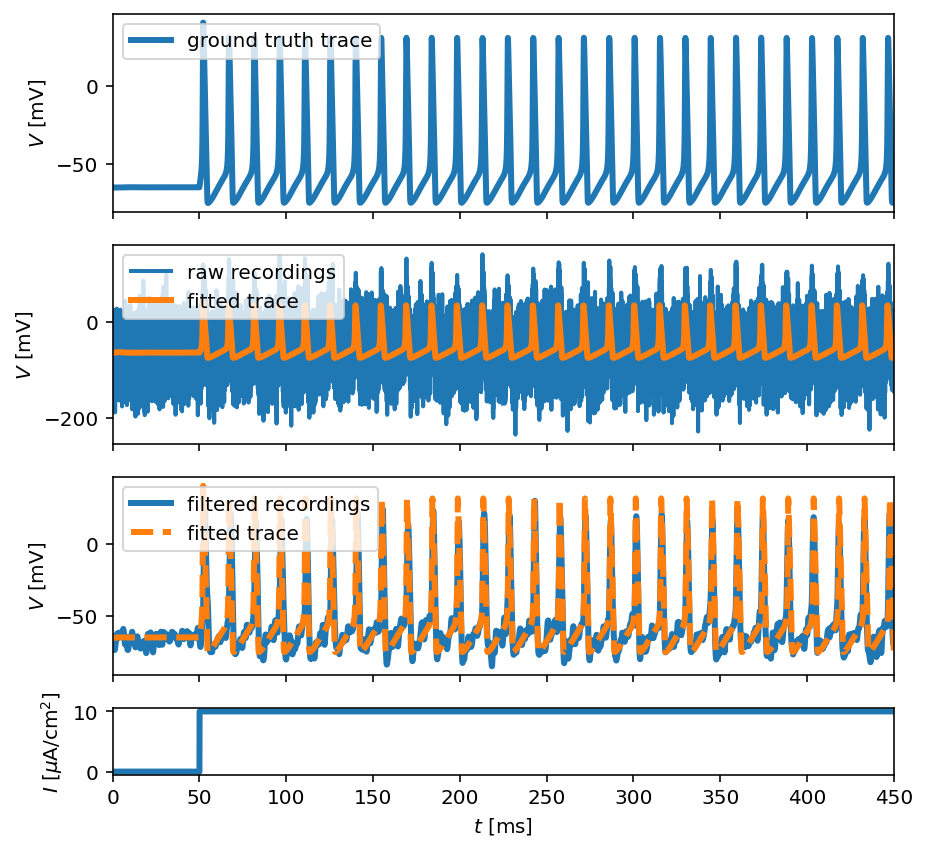

In [12]:
# visualize fitted traces w.r.t. ground truth, measured traces and filtered traces
t = np.arange(0, out_trace_ground_truth.size*dt/ms, dt/ms)
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [3, 3, 3, 1]}, figsize=(7, 7))
# ground truth
ax[0].plot(t, out_trace_ground_truth, lw=3, label='ground truth trace')
ax[0].set_ylabel(r'$V$ [mV]')
ax[0].legend()

# measured noisy trace and fitted traces w.r.t. measured nosiy trace
ax[1].plot(t, ret_measured['recordings'], lw=2, label='raw recordings')
ax[1].plot(t, ret_measured['fitted_traces'], lw=3, label='fitted trace')
ax[1].set_ylabel(r'$V$ [mV]')
ax[1].legend()

# filtered trace and fitted traces w.r.t. filtered trace
ax[2].plot(t, ret_filtered['recordings'], lw=3, label='filtered recordings')
ax[2].plot(t, ret_filtered['fitted_traces'], '--', lw=3, label='fitted trace')
ax[2].set_ylabel(r'$V$ [mV]')
ax[2].legend()

# stimulus
ax[3].plot(t, inp_trace, lw=3)
ax[3].set(xlabel=r'$t$ [ms]', ylabel=r'$I$ [$\mu$A/cm$^2$]',
          xlim=[0, 450]);